In [1]:
!pip install -q flask flask-ngrok tensorflow
!pip install pyngrok
!pip install bangla-stemmer

In [2]:
# training a cyberbullying sentiment analysis model
#importing all the necessary libraries
import os, re, json
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, \
    Bidirectional, LSTM, concatenate, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from flask_ngrok import run_with_ngrok
import sys
from bangla_stemmer.stemmer import stemmer
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# ---------- Data Loading ----------
DATA_PATH = "/content/CyberBulling_Dataset_Bangla.xlsx"  # update path if needed
OUTPUT_DIR = "output_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)
df = pd.read_excel(DATA_PATH)

print(df.head())
VOCAB_SIZE = 20000
EMBED_DIM = 200
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 12

   Unnamed: 0                                        Description   Label
0           0  ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...  sexual
1           1  আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...  sexual
2           2  ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...  sexual
3           3                                     বোকাচোদা একটা।  sexual
4           4  তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...  sexual


In [4]:
# ----------------------------Data Preprocessing--------------------
def clean_text(text):
    text = str(text)

    # For removing URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    #To remove mentions/hashtags
    text = re.sub(r'@\w+|#\w+', ' ', text)

    # To remove emojis (Unicode ranges)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002700-\U000027BF"  # dingbats
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(' ', text)

    #To remove latin letters and digits
    text = re.sub(r'[A-Za-z0-9]', ' ', text)

    #To collapse spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [5]:

# Create a list of stopwords
stop_words_list = ['না','ও','করে','এই','আর','আর','কি']

def remove_custom_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_list]
    return ' '.join(filtered_words)

# Apply the function to the 'text' column
df['Description'] = df['Description'].apply(remove_custom_stopwords)

In [6]:
def bangla_stemming(text):
    wordlist = text.split()  # Split text into words
    stmr = stemmer.BanglaStemmer()
    original_stdout = sys.stdout
    sys.stdout = open('temp', 'w')
    stm = stmr.stem(wordlist)
    sys.stdout.close()
    sys.stdout = original_stdout
    return ' '.join(stm)  # Join stemmed words back into text

# Apply stemming function to DataFrame column
df['Description'] = df['Description'].apply(lambda x: bangla_stemming(x))

In [7]:
# Load data
df = pd.read_excel(DATA_PATH)
df['text'] = df['Description'].astype(str).apply(clean_text)
df['label'] = df['Label'].astype(str)
df['Label'].value_counts()

,count
Label,
Political,1205
troll,1202
sexual,1201
Threat,1201
Neutral,1201


In [8]:
# Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# Splits (stratified): train 70%, val 15%, test 15%
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label_enc'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.17647058823, stratify=train_df['label_enc'], random_state=42)


Classes: ['Neutral', 'Political', 'Threat', 'sexual', 'troll']


In [9]:
# Tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])
def texts_to_padded(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train = texts_to_padded(train_df['text'])
X_val = texts_to_padded(val_df['text'])
X_test = texts_to_padded(test_df['text'])
y_train = tf.keras.utils.to_categorical(train_df['label_enc'], num_classes)
y_val = tf.keras.utils.to_categorical(val_df['label_enc'], num_classes)
y_test = tf.keras.utils.to_categorical(test_df['label_enc'], num_classes)

In [10]:
# Model builders
def build_cnn():
    inp = Input(shape=(MAX_LEN,))
    x = Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN)(inp)
    convs = []
    for k in [3,4,5]:
        c = Conv1D(filters=128, kernel_size=k, activation='relu')(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)
    x = concatenate(convs)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm():
    inp = Input(shape=(MAX_LEN,))
    x = Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN)(inp)
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_lstm():
    inp = Input(shape=(MAX_LEN,))
    x = Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN)(inp)
    x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(build_fn, name):
    model = build_fn()
    ckpt = ModelCheckpoint(os.path.join(OUTPUT_DIR, f"{name}.h5"), monitor='val_loss', save_best_only=True)
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[ckpt, es, rl], verbose=2)
    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    preds = model.predict(X_test, verbose=0)
    pred_labels = preds.argmax(axis=1)
    true = y_test.argmax(axis=1)
    cr = classification_report(true, pred_labels, target_names=list(le.classes_), output_dict=True)
    cm = confusion_matrix(true, pred_labels)
    # save artifacts
    pd.DataFrame(cr).transpose().to_csv(os.path.join(OUTPUT_DIR, f"{name}_report.csv"))
    np.save(os.path.join(OUTPUT_DIR, f"{name}_confusion.npy"), cm)
    # tokenizer and label mapping
    with open(os.path.join(OUTPUT_DIR, "tokenizer.json"), "w", encoding="utf-8") as f:
        f.write(tokenizer.to_json())
    with open(os.path.join(OUTPUT_DIR, "label_mapping.json"), "w", encoding="utf-8") as f:
        json.dump({c:int(i) for c,i in zip(le.classes_, le.transform(le.classes_))}, f, ensure_ascii=False, indent=2)
    return {
    "name": name,
    "test_loss": float(test_loss),
    "test_acc": float(test_acc),
    "history": hist.history
}

results = []
results.append(train_model(build_cnn, "CNN"))
results.append(train_model(build_bilstm, "BiLSTM"))
results.append(train_model(build_cnn_lstm, "CNN-LSTM"))
pd.DataFrame(results).drop(columns=["history"]).to_csv(
    os.path.join(OUTPUT_DIR, "models_summary.csv"),
    index=False
)
print("Done. Outputs saved to", OUTPUT_DIR)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/12


132/132 - 11s - 83ms/step - accuracy: 0.4073 - loss: 1.3669 - val_accuracy: 0.5488 - val_loss: 1.0840 - learning_rate: 1.0000e-03
Epoch 2/12


132/132 - 1s - 8ms/step - accuracy: 0.7741 - loss: 0.6664 - val_accuracy: 0.7084 - val_loss: 0.8356 - learning_rate: 1.0000e-03
Epoch 3/12
132/132 - 1s - 7ms/step - accuracy: 0.9505 - loss: 0.1646 - val_accuracy: 0.6951 - val_loss: 0.9743 - learning_rate: 1.0000e-03
Epoch 4/12
132/132 - 1s - 7ms/step - accuracy: 0.9917 - loss: 0.0364 - val_accuracy: 0.6840 - val_loss: 1.1188 - learning_rate: 1.0000e-03
Epoch 5/12
132/132 - 1s - 7ms/step - accuracy: 0.9983 - loss: 0.0113 - val_accuracy: 0.6918 - val_loss: 1.1361 - learning_rate: 5.0000e-04
Epoch 1/12


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 - 9s - 70ms/step - accuracy: 0.3702 - loss: 1.4013 - val_accuracy: 0.5410 - val_loss: 1.1002 - learning_rate: 1.0000e-03
Epoch 2/12


132/132 - 2s - 17ms/step - accuracy: 0.7014 - loss: 0.7479 - val_accuracy: 0.6197 - val_loss: 1.0770 - learning_rate: 1.0000e-03
Epoch 3/12
132/132 - 2s - 16ms/step - accuracy: 0.9025 - loss: 0.2855 - val_accuracy: 0.6242 - val_loss: 1.2204 - learning_rate: 1.0000e-03
Epoch 4/12
132/132 - 3s - 22ms/step - accuracy: 0.9734 - loss: 0.0866 - val_accuracy: 0.6197 - val_loss: 1.5267 - learning_rate: 1.0000e-03
Epoch 5/12
132/132 - 2s - 17ms/step - accuracy: 0.9945 - loss: 0.0266 - val_accuracy: 0.6386 - val_loss: 1.6717 - learning_rate: 5.0000e-04
Epoch 1/12


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 - 5s - 39ms/step - accuracy: 0.3217 - loss: 1.4566 - val_accuracy: 0.4756 - val_loss: 1.1868 - learning_rate: 1.0000e-03
Epoch 2/12


132/132 - 2s - 18ms/step - accuracy: 0.6405 - loss: 0.8873 - val_accuracy: 0.5998 - val_loss: 1.0263 - learning_rate: 1.0000e-03
Epoch 3/12
132/132 - 2s - 16ms/step - accuracy: 0.8462 - loss: 0.4199 - val_accuracy: 0.6297 - val_loss: 1.1892 - learning_rate: 1.0000e-03
Epoch 4/12
132/132 - 2s - 14ms/step - accuracy: 0.9586 - loss: 0.1308 - val_accuracy: 0.6242 - val_loss: 1.5042 - learning_rate: 1.0000e-03
Epoch 5/12
132/132 - 2s - 14ms/step - accuracy: 0.9914 - loss: 0.0310 - val_accuracy: 0.6475 - val_loss: 1.7200 - learning_rate: 5.0000e-04
Done. Outputs saved to output_models


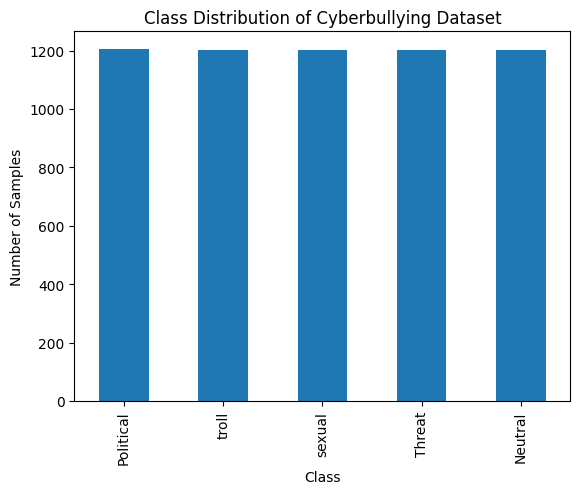

In [11]:
df['Label'].value_counts().plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Cyberbullying Dataset")
plt.show()

In [12]:
!ls /content/output_models


BiLSTM_confusion.npy	    model_bilstm.h5
BiLSTM.h5		    model_bilstm_report.csv
BiLSTM_report.csv	    model_cnn_confusion.npy
CNN_confusion.npy	    model_cnn.h5
CNN.h5			    model_cnn_lstm_confusion.npy
CNN-LSTM_confusion.npy	    model_cnn_lstm.h5
CNN-LSTM.h5		    model_cnn_lstm_report.csv
CNN-LSTM_report.csv	    model_cnn_report.csv
CNN_report.csv		    models_summary.csv
label_mapping.json	    tokenizer.json
model_bilstm_confusion.npy


In [13]:
from flask import Flask, request, jsonify
from pyngrok import ngrok
ngrok.set_auth_token("36sdiPv3OLa5AfGrNwKHpNLk5cL_3NKgZK7z1wf6LBBQZoDUR")
import tensorflow as tf
import numpy as np
import json
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import threading

# -----------------------------
# Initialize Flask
# -----------------------------
app = Flask(__name__)

# -----------------------------
# Load model and tokenizer
# -----------------------------
MODEL_PATH = "/content/output_models/model_cnn.h5"
model = tf.keras.models.load_model(MODEL_PATH)

with open("/content/output_models/tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer = tokenizer_from_json(f.read())

with open("/content/output_models/label_mapping.json", "r", encoding="utf-8") as f:
    label_map = json.load(f)
inv_label_map = {int(v): k for k, v in label_map.items()}

MAX_LEN = 128

# -----------------------------
# Text cleaning function
# -----------------------------
def clean_text(text):
    text = str(text)

    # For removing URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    #To remove mentions/hashtags
    text = re.sub(r'@\w+|#\w+', ' ', text)

    # To remove emojis (Unicode ranges)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002700-\U000027BF"  # dingbats
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(' ', text)

    #To remove latin letters and digits
    text = re.sub(r'[A-Za-z0-9]', ' ', text)

    #To collapse spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# -----------------------------
# Taking you to Webpage
# -----------------------------
@app.route("/", methods=["GET"])
def home():

    # HTML form for Evalucating Bangla input text and show result
    return '''
    <h2>Cyberbullying Detection (Bangla)</h2>
    <style>
    textarea { font-size: 16px; padding: 10px; }
    input[type=submit] { font-size: 16px; padding: 5px 15px; }
    </style>
    <p>Type Bangla text below to check for cyberbullying:</p>
    <form method="post" action="/predict">
        <textarea name="text" rows="5" cols="60"></textarea><br><br>
        <input type="submit" value="Predict">
    </form>
    '''

# -----------------------------
# For prediction
# -----------------------------
@app.route("/predict", methods=["POST"])
def predict():
    # Get text from form submission or JSON
    if request.is_json:
        data = request.get_json()
        text = data.get("text", "")
    else:
        text = request.form.get("text", "")

    # Preprocess
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    probs = model.predict(pad)[0]
    idx = int(np.argmax(probs))

    result = {
        "input_text": text,
        "predicted_label": inv_label_map[idx],
        "confidence": float(np.max(probs)),
        "class_probabilities": {inv_label_map[i]: float(p) for i, p in enumerate(probs)}
    }

    # If submitted through HTML form it will show you in the page
    if not request.is_json:
        return f"""
        <h3>Prediction Result</h3>
        <p><b>Input:</b> {text}</p>
        <p><b>Predicted Class:</b> {result['predicted_label']}</p>
        <p><b>Confidence:</b> {result['confidence']:.2f}</p>
        <a href="/">Go Back</a>
        """

    return jsonify(result)


public_url = ngrok.connect(5000)
print("🚀 Public URL:", public_url)

def run_app():
    app.run(port=5000)

thread = threading.Thread(target=run_app)
thread.daemon = True
thread.start()

print("Flask server started in background")


🚀 Public URL: NgrokTunnel: "https://unequine-pseudoambidextrously-malisa.ngrok-free.dev" -> "http://localhost:5000"
Flask server started in background
 * Serving Flask app '__main__'
 * Debug mode: off


In [14]:
#Testing is the url is working or not
import requests
print(requests.get("http://127.0.0.1:5000/").text)


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [15/Dec/2025 15:04:33] "GET / HTTP/1.1" 200 -



    <h2>Cyberbullying Detection (Bangla)</h2>
    <style>
    textarea { font-size: 16px; padding: 10px; }
    input[type=submit] { font-size: 16px; padding: 5px 15px; }
    </style>
    <p>Type Bangla text below to check for cyberbullying:</p>
    <form method="post" action="/predict">
        <textarea name="text" rows="5" cols="60"></textarea><br><br>
        <input type="submit" value="Predict">
    </form>
    


In [15]:
#Testing API
import requests

data = {"text": "সবাই পারে না · শুধু তোমাকেই"}
r = requests.post("http://127.0.0.1:5000/predict", json=data)
print(r.json())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


INFO:werkzeug:127.0.0.1 - - [15/Dec/2025 15:04:34] "POST /predict HTTP/1.1" 200 -


{'class_probabilities': {'Neutral': 0.39324241876602173, 'Political': 0.02371605485677719, 'Threat': 0.04974659904837608, 'sexual': 0.16537344455718994, 'troll': 0.36792150139808655}, 'confidence': 0.39324241876602173, 'input_text': 'সবাই পারে না · শুধু তোমাকেই', 'predicted_label': 'Neutral'}


In [16]:
#Testing API
import requests

url = "https://unequine-pseudoambidextrously-malisa.ngrok-free.dev/predict"  # use your URL

data = {
    "text": "ছাগলটা আর ছাগলের বাচ্চা হয়ছে. ঠিক আছে. সেই জন্য ছাগলকে খাবার দিতে হবে. হাসানি দিতে হবে. "
}

r = requests.post(url, json=data)
print(r.json())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:werkzeug:127.0.0.1 - - [15/Dec/2025 15:04:35] "POST /predict HTTP/1.1" 200 -


{'class_probabilities': {'Neutral': 0.08380844444036484, 'Political': 0.1599685698747635, 'Threat': 0.019509410485625267, 'sexual': 0.06840116530656815, 'troll': 0.6683123707771301}, 'confidence': 0.6683123707771301, 'input_text': 'ছাগলটা আর ছাগলের বাচ্চা হয়ছে. ঠিক আছে. সেই জন্য ছাগলকে খাবার দিতে হবে. হাসানি দিতে হবে. ', 'predicted_label': 'troll'}


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


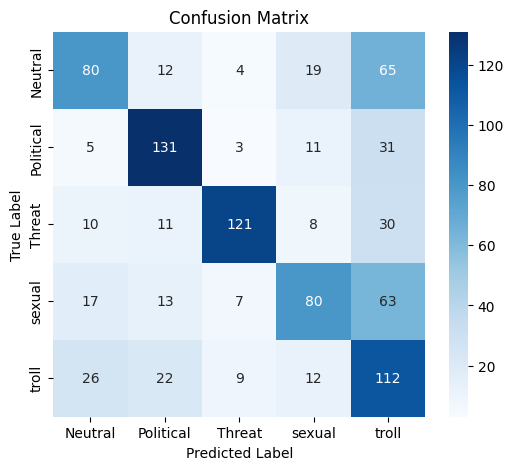

In [17]:
#Confusion Matrix Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [18]:
#Classification Report (Precision, Recall, F1-Score)
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=le.classes_
))


              precision    recall  f1-score   support

     Neutral       0.58      0.44      0.50       180
   Political       0.69      0.72      0.71       181
      Threat       0.84      0.67      0.75       180
      sexual       0.62      0.44      0.52       180
       troll       0.37      0.62      0.46       181

    accuracy                           0.58       902
   macro avg       0.62      0.58      0.59       902
weighted avg       0.62      0.58      0.59       902



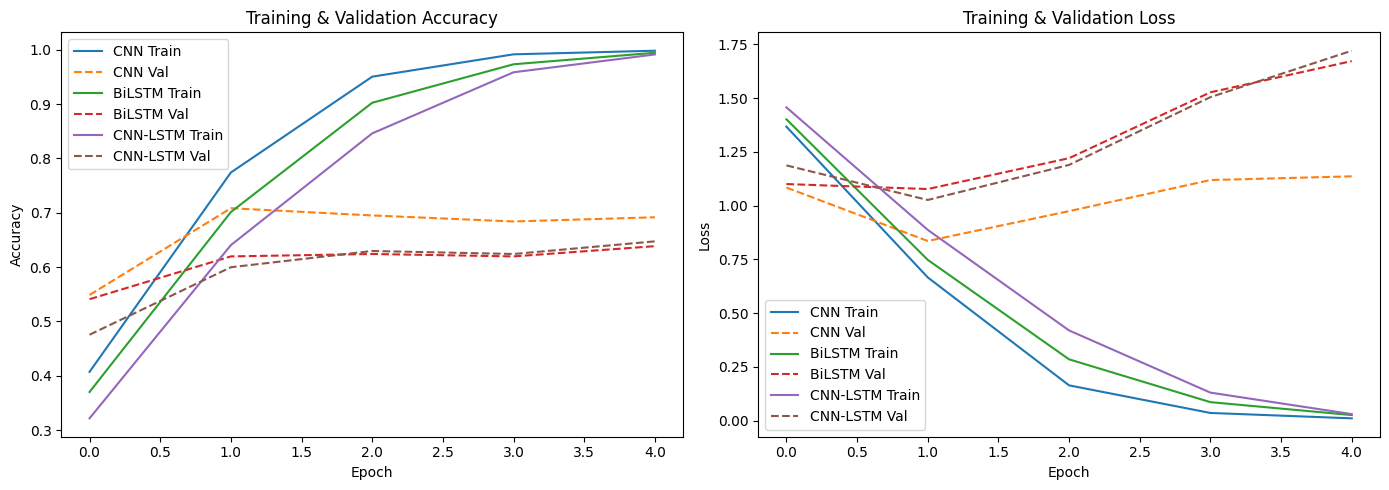

In [19]:
#Training History Visualization (Accuracy & Loss)
plt.figure(figsize=(14,5))

# -------- Accuracy --------
plt.subplot(1,2,1)
for r in results:
    plt.plot(r["history"]["accuracy"], label=f'{r["name"]} Train')
    plt.plot(r["history"]["val_accuracy"], linestyle='--', label=f'{r["name"]} Val')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# -------- Loss --------
plt.subplot(1,2,2)
for r in results:
    plt.plot(r["history"]["loss"], label=f'{r["name"]} Train')
    plt.plot(r["history"]["val_loss"], linestyle='--', label=f'{r["name"]} Val')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

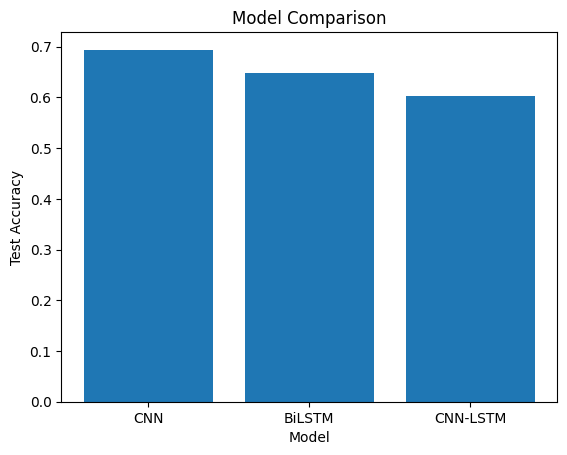

In [20]:
#Comparison of Models
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/output_models/models_summary.csv")

plt.bar(df['name'], df['test_acc'])
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.title("Model Comparison")
plt.show()